# Assignment 8

In this project, you will explore and analyze a public dataset of your choosing. Since this assignment is “open-ended” in nature, you are free to expand upon the requirements below. You may use a .ipynb file instead of .py.

You must add descriptions to each of the sections. You must explain what your code is doing (either in comments or via the supported HTML inside of a .ipynb file).

### Data Resources

• https://www.data.gov/

• https://opendata.cityofnewyork.us/

• https://datasetsearch.research.google.com/

• https://archive.ics.uci.edu/ml/index.php


In [556]:
# Load all the necessary libraries - most will be added as the code progresses and are required

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error


# I will be working with the housing data set available in kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

# A brief overview of the Kaggle Housing Data
'''
Kaggle housing dataset competition entails the exploration of data with 79 exploratory variables challenging competitiors
to predict the final price of homes on previously unseen data.

This data was compiled by "Dean De Cock" according to Kaggle.com.

'''

# Training Set
df_train = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/train.csv')

# Set the Id column to be the index
df_train.set_index(['Id'])

# Drop the Id column since its not necessary for this subsequent analytics
df_train = df_train.drop(['Id'], axis = 1)

# View the number of columns and print out the first 5 rows to ensure the data is loaded correctly.
print(df_train.shape) # Data contains 1460 rows and 80 colums (Id column dropped)
df_train.head() # Note some columns already show missing data


(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Database Connection

##### (Optional Extra Credit)

Import the data you've selected into a SQL database of your choosing. Connect your database to Python.

### Resources:

https://dev.mysql.com/doc/workbench/en/wb-admin-export-import-table.html
https://medium.com/@tattwei46/how-to-use-python-with-mysql-79304bee8753
https://downloads.mysql.com/docs/connector-python-en.pdf
https://datatofish.com/how-to-connect-python-to-sql-server-using-pyodbc/


In [557]:
# We start by importing mysql-connector (pip install mysql-connector if not already installed)
#pip install mysql-connector
import mysql.connector

# Upload data from a csv file into MYSQL - I used my workbench data import wizard.
# Create a python mysql connection 
cnx = mysql.connector.connect(user='root', password='Sammiggy2030^', host='localhost', database='housingdata')

# Test whether the cinnecton has been established successfully
print(cnx)

cursor = cnx.cursor()

# Lets select Id and SalePrice columns from our train table in housingdata database and filter by SalePrice greater than $500000.
sql = "SELECT Id, SalePrice FROM train WHERE SalePrice > 500000"

# Execute the query and fetch the required data
cursor.execute(sql)
myresult = cursor.fetchall()

print('There are', len(myresult), 'houses with a price greater that $500,000 in our dataset.\n \n Id,  SalePrice')

num = 0

# Loop through the data and print out the output one by one
for x in myresult:
    num = num + 1
    print(x)
    #print(num)

# Close the connection
cnx.close

There are 9 houses with a price greater that $500,000 in our dataset.
 
 Id,  SalePrice
(179, 501837)
(441, 555000)
(692, 755000)
(770, 538000)
(804, 582933)
(899, 611657)
(1047, 556581)
(1170, 625000)
(1183, 745000)


<bound method MySQLConnection.close of <mysql.connector.connection.MySQLConnection object at 0x000001C83ACC6248>>

# Data Exploration (EDA)

Import your dataset into your python environment and explore your data. 
You should include any summary statistics, means, medians, quartiles, or any other relevant information about the dataset.


In [558]:
# We will perform summary statistics on a subset of the train data set from the housing data

'''
We begin by checking for correlation between the exploratory variables (79) and the target variable ("SalePrice").

A subset of the data will be created that includes columns with numbers.
'''

# Uncomment the line below to view the no of columns and their respective data types
#print(df_train.info())

# The subset will be made up of only columns with numbers 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sub_df_train = df_train.select_dtypes(include=numerics)

# Uncomment the line below to view the no of columns and the resulting data types
sub_df_train.info() # The above operation narrows down from 80 to 37 columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
G

In [559]:
# The code below outputs the count, mean, std, min, 1st, 2nd and 3rd quantiles and the max for each of the variables (columns)
print(sub_df_train.describe().transpose()) # Use the transpose function for a beteer view of the results

'''
We can eliminate variables with missing and or limited features through a careful review
of the summary statists below.
'''

                count           mean           std      min        25%  \
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712  

'\nWe can eliminate variables with missing and or limited features through a careful review\nof the summary statists below.\n'

In [560]:
# We create a corellation matrix to view the relationship between the different variables
# and select those with the greatest correlation for further analysis.
print(sub_df_train.corr())

               MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.386347 -0.139781     0.032628    -0.059316   
LotFrontage     -0.386347     1.000000  0.426095     0.251646    -0.059213   
LotArea         -0.139781     0.426095  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.251646  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.059213 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.123349  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.088866  0.013788     0.550684     0.073741   
MasVnrArea       0.022936     0.193458  0.104160     0.411876    -0.128101   
BsmtFinSF1      -0.069836     0.233633  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649     0.049900  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.132644 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.392075  0.260833     0.537808   

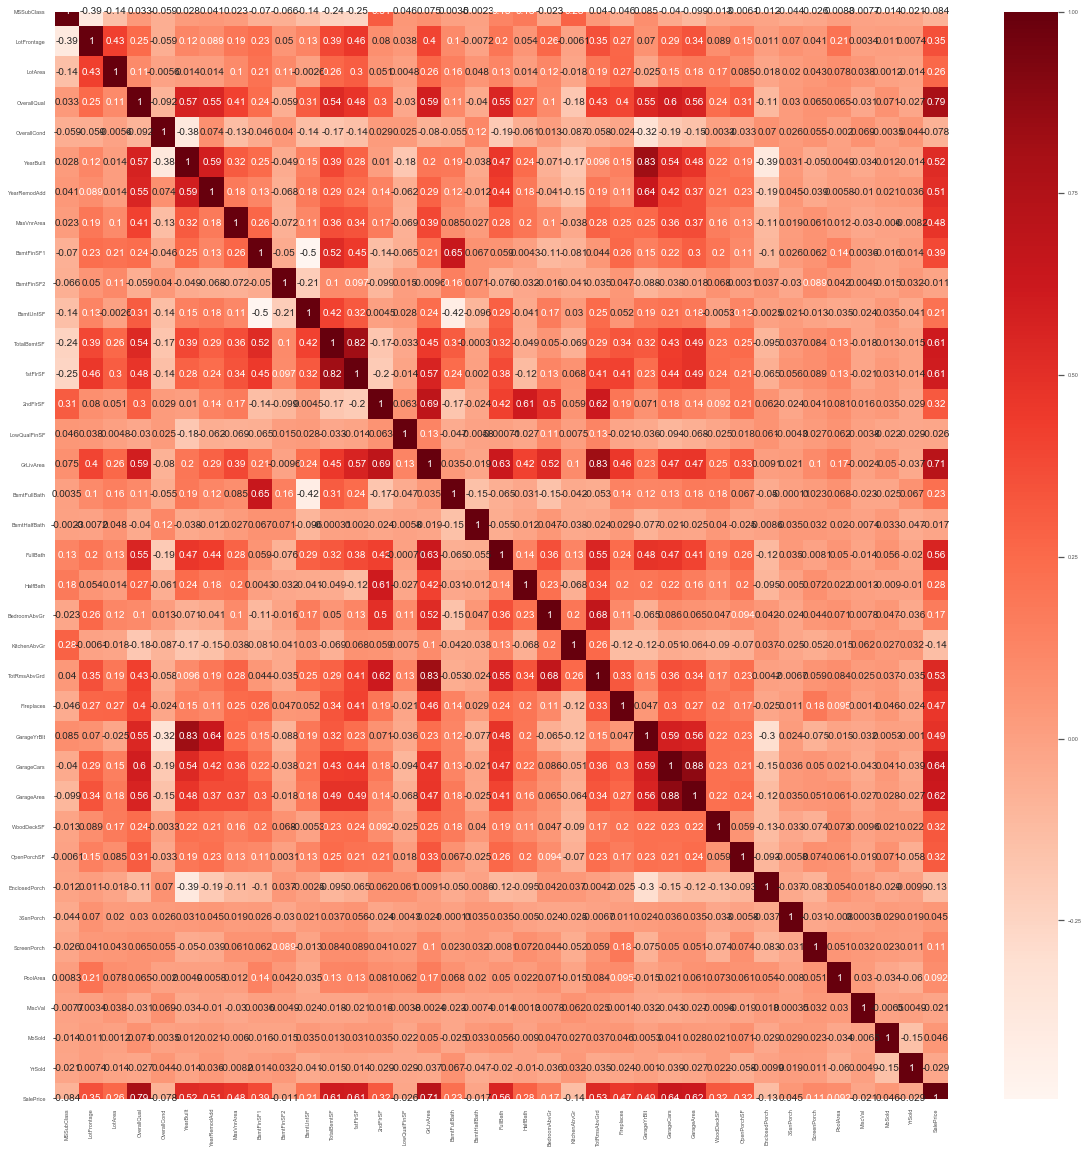

In [561]:
# Visualize the correlations graphically Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = sub_df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [562]:
'''
We will select features with high correlation to the target variable and
create a new subset for further analysis
'''
# Correlation with output variable
target_cor = abs(cor['SalePrice'])

# Select only variables with highly correlated features ie. those above 0.40
desired_features = target_cor[target_cor > 0.40]
print(desired_features)

# Create a data frame with only these desired features for further analysis
df_rel = sub_df_train[['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
                      'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']]

# View the new data frame for completeness
df_rel.head()

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64


,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,856,856,1710,2,8,0,2003.0,2,548,208500
1,6,1976,1976,0.0,1262,1262,1262,2,6,1,1976.0,2,460,181500
2,7,2001,2002,162.0,920,920,1786,2,6,1,2001.0,2,608,223500
3,7,1915,1970,0.0,756,961,1717,1,7,1,1998.0,3,642,140000
4,8,2000,2000,350.0,1145,1145,2198,2,9,1,2000.0,3,836,250000


In [563]:
# We create a corellation matrix to view the relationship between the selected variables
# Those with the greatest correlation to the SalePrice.
print(df_rel.corr())


              OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  TotalBsmtSF  \
OverallQual      1.000000   0.572323      0.550684    0.411876     0.537808   
YearBuilt        0.572323   1.000000      0.592855    0.315707     0.391452   
YearRemodAdd     0.550684   0.592855      1.000000    0.179618     0.291066   
MasVnrArea       0.411876   0.315707      0.179618    1.000000     0.363936   
TotalBsmtSF      0.537808   0.391452      0.291066    0.363936     1.000000   
1stFlrSF         0.476224   0.281986      0.240379    0.344501     0.819530   
GrLivArea        0.593007   0.199010      0.287389    0.390857     0.454868   
FullBath         0.550600   0.468271      0.439046    0.276833     0.323722   
TotRmsAbvGrd     0.427452   0.095589      0.191740    0.280682     0.285573   
Fireplaces       0.396765   0.147716      0.112581    0.249070     0.339519   
GarageYrBlt      0.547766   0.825667      0.642277    0.252691     0.322445   
GarageCars       0.600671   0.537850      0.420622  

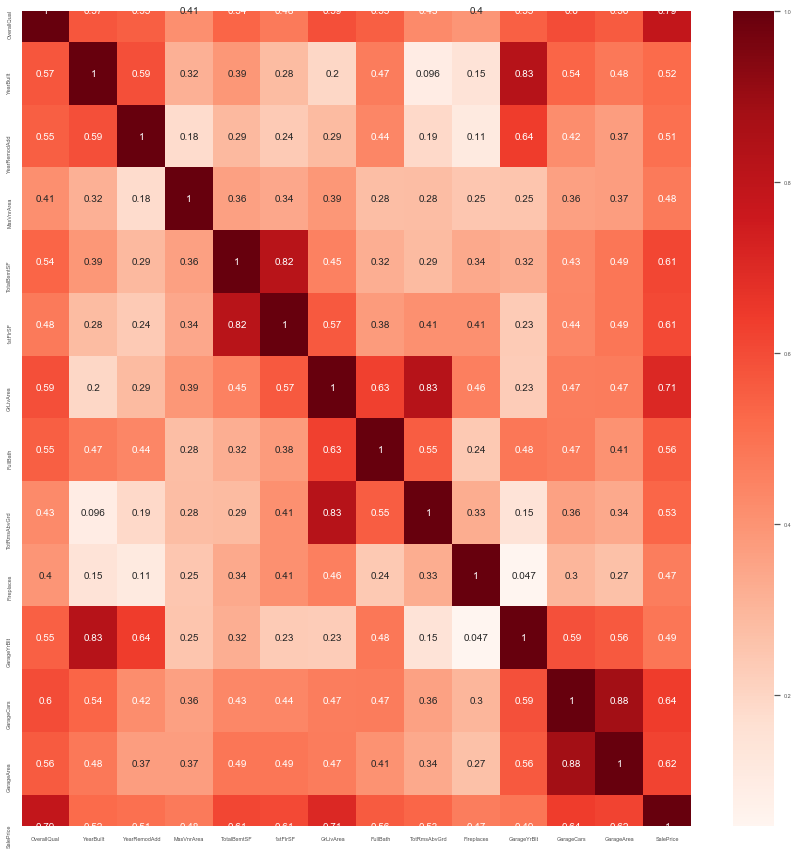

In [564]:
# Visualize the correlation coefficient of the selected variables
plt.figure(figsize=(15,15))
cor = df_rel.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Data Wrangling/Cleaning

Please perform some basic transformations/data manipulations.

### Resources:

https://pandas.pydata.org/docs/user_guide/index.html


In [565]:
# We are going to perform various transformation on the final dataset from above

# Create a copy of the data frame
df = df_rel

# Perform a check of whether any of the values are missing
print('Is there missing values: ', df.isnull().values.any(),'\n') # True if there are missing values and False if not.

# To print total count of missing values per column (MasVnrArea - 8NA's, GarageYrBlt - 81NA's)
print(df.isnull().sum(),'\n')

# To put put total missing values
print('Total missing values: ', df.isnull().sum().sum(),'\n') 

# Replace all the NA's with 0 for the columns with missing data.
df1 = df.fillna(0)

# To print out total count of missing values
print('Missing values after replacing all NAs with 0: ', df1.isnull().sum().sum())


Is there missing values:  True 

OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       8
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt     81
GarageCars       0
GarageArea       0
SalePrice        0
dtype: int64 

Total missing values:  89 

Missing values after replacing all NAs with 0:  0


# Data Visualizations

Include supporting data visualizations here. 
You may use any visualization library of your choice. 
You must explain what each visualization is showing.

### Resources:

https://plotly.com/python/plotly-express/
https://seaborn.pydata.org/introduction.html
https://matplotlib.org/
    

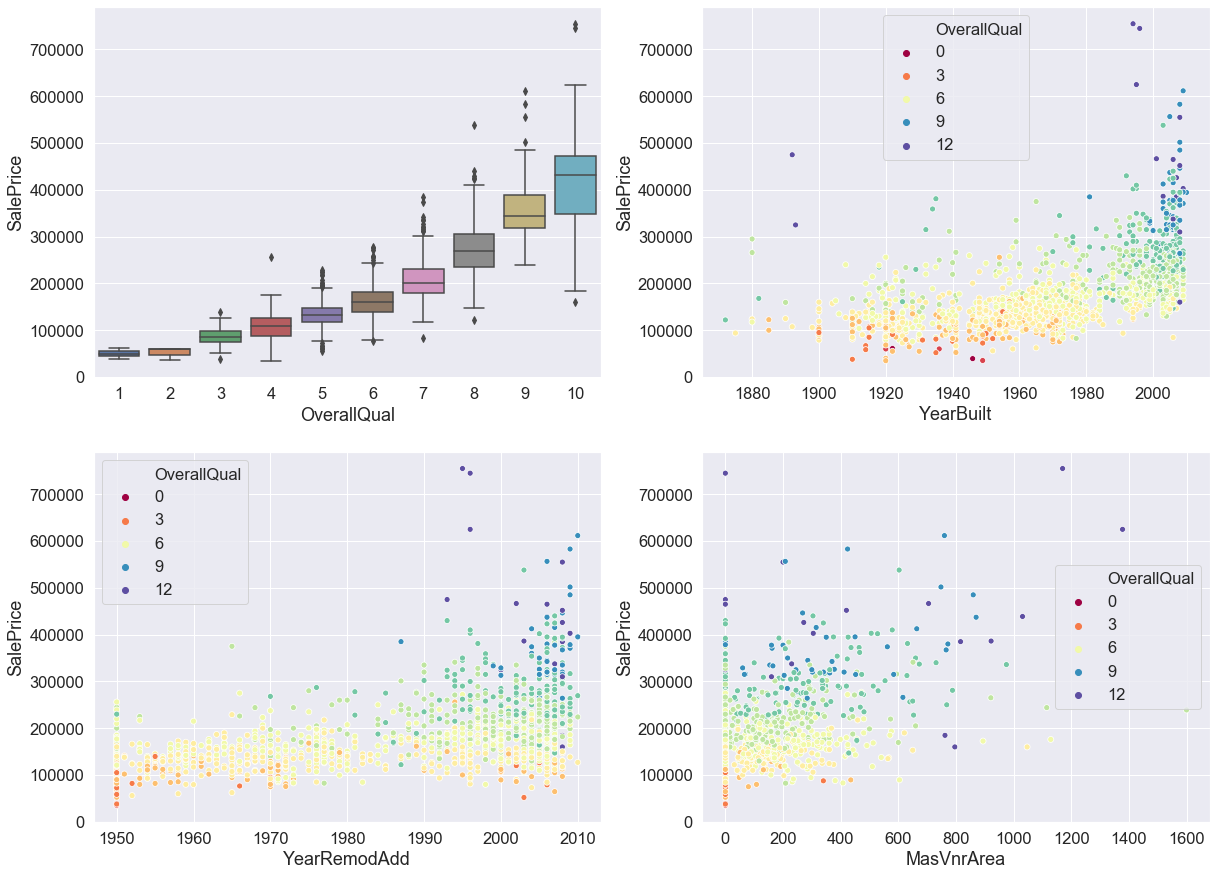

In [566]:
'''
I have included a boxplot visualization for OverallQual - Which has the highest correlation with SalePrice

Visualize "OverallQual", "YearBuilt", "YearRemodAdd", "MasVnrArea" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality.
'''
df1 = df1
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig1 = fig.add_subplot(221)
sns.boxplot(x='OverallQual', y='SalePrice', data=df1[['SalePrice', 'OverallQual']])

fig2 = fig.add_subplot(222); 
sns.scatterplot(x = df1.YearBuilt, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig3 = fig.add_subplot(223); 
sns.scatterplot(x = df1.YearRemodAdd, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig4 = fig.add_subplot(224); 
sns.scatterplot(x = df1.MasVnrArea, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')


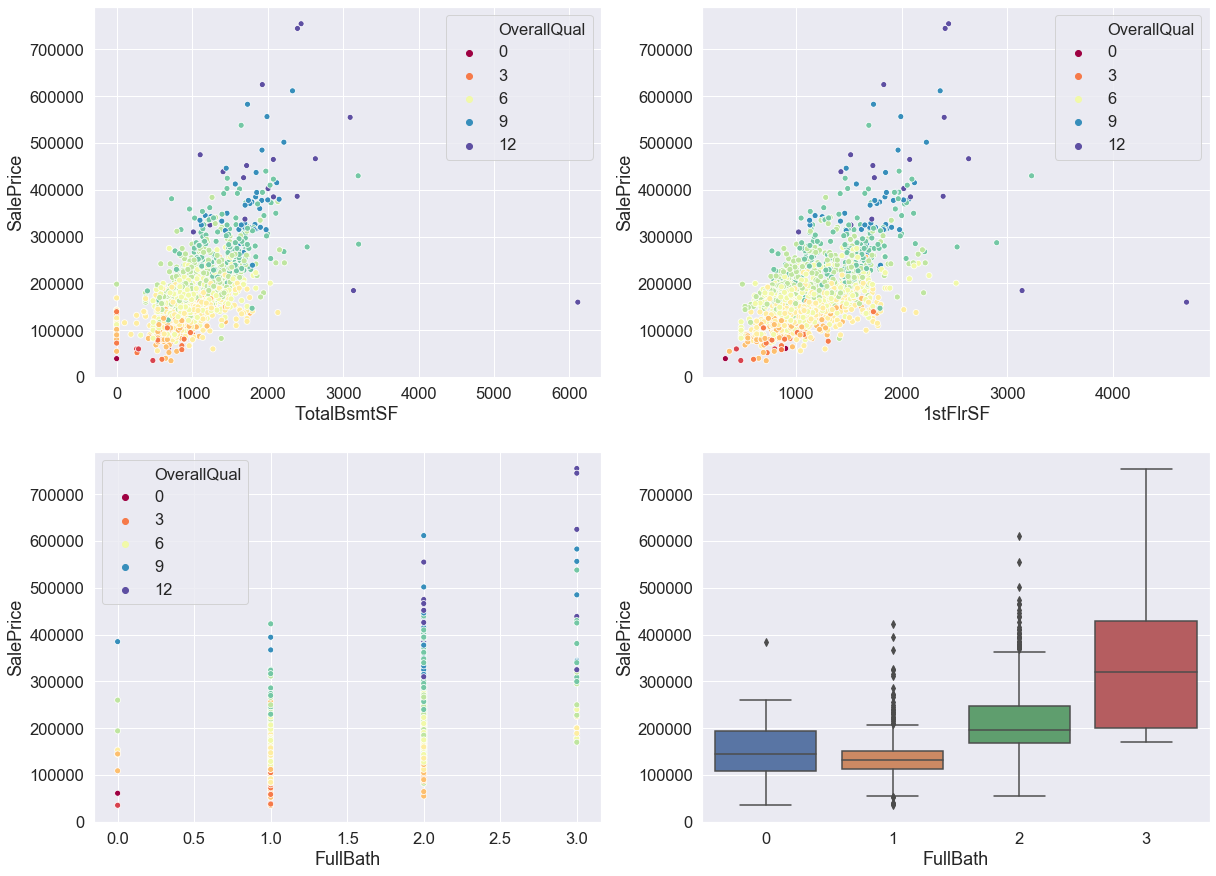

In [567]:
'''
Visualize "TotalBsmtSF", "1stFlrSF", "FullBath" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for FullBath
'''

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig5 = fig.add_subplot(221); 
sns.scatterplot(x = df1.TotalBsmtSF, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig6 = fig.add_subplot(222); 
sns.scatterplot(x = df1['1stFlrSF'], y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig8 = fig.add_subplot(223); 
sns.scatterplot(x = df1.FullBath, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig8_1 = fig.add_subplot(224); 
sns.boxplot(x='FullBath', y='SalePrice', data=df1[['SalePrice', 'FullBath']])


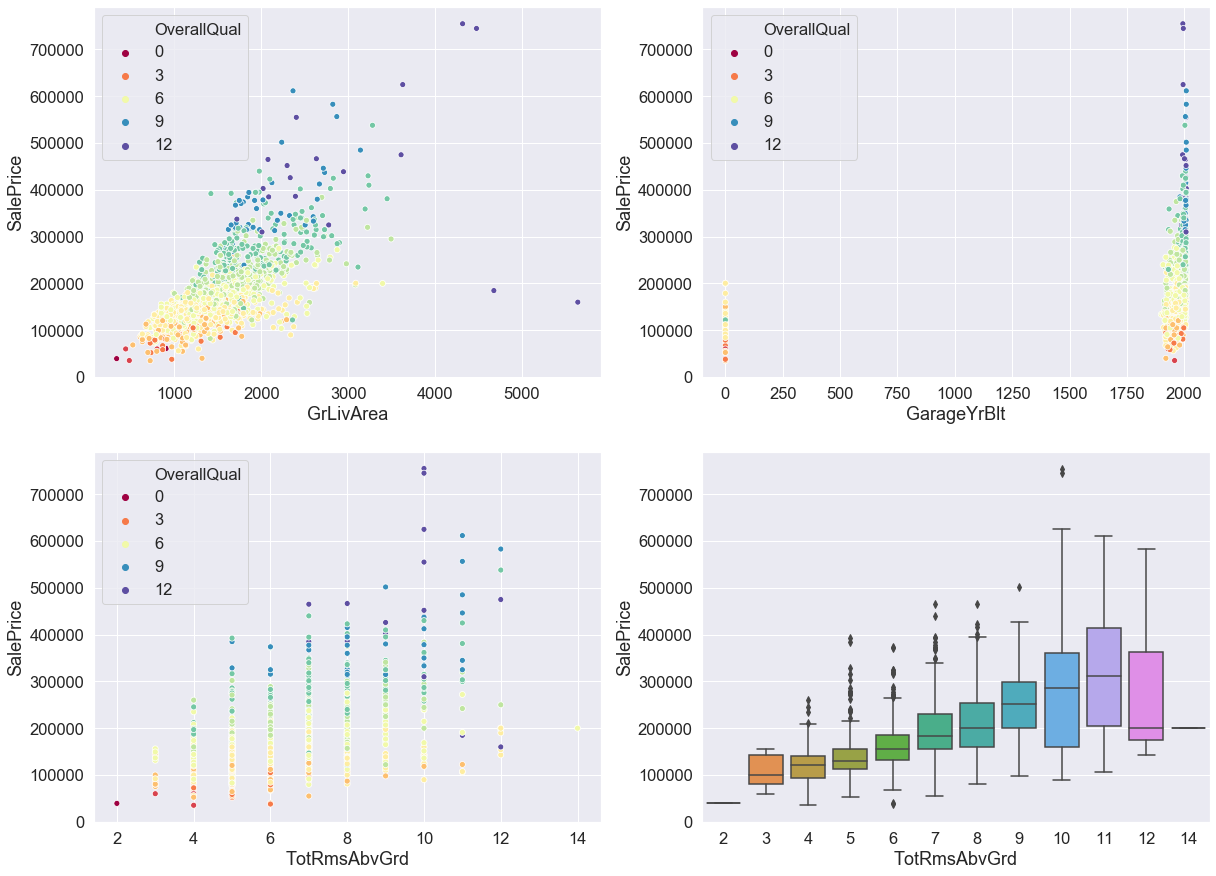

In [568]:
'''
Visualize "GrLivArea", "TotRmsAbvGrd","GarageYrBlt" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for TotRmsAbvGrd
'''
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig7 = fig.add_subplot(221); 
sns.scatterplot(x = df1.GrLivArea, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig10 = fig.add_subplot(222); 
sns.scatterplot(x = df1.GarageYrBlt, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig9 = fig.add_subplot(223); 
sns.scatterplot(x = df1.TotRmsAbvGrd, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig9_1 = fig.add_subplot(224); 
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=df1[['SalePrice', 'TotRmsAbvGrd']])


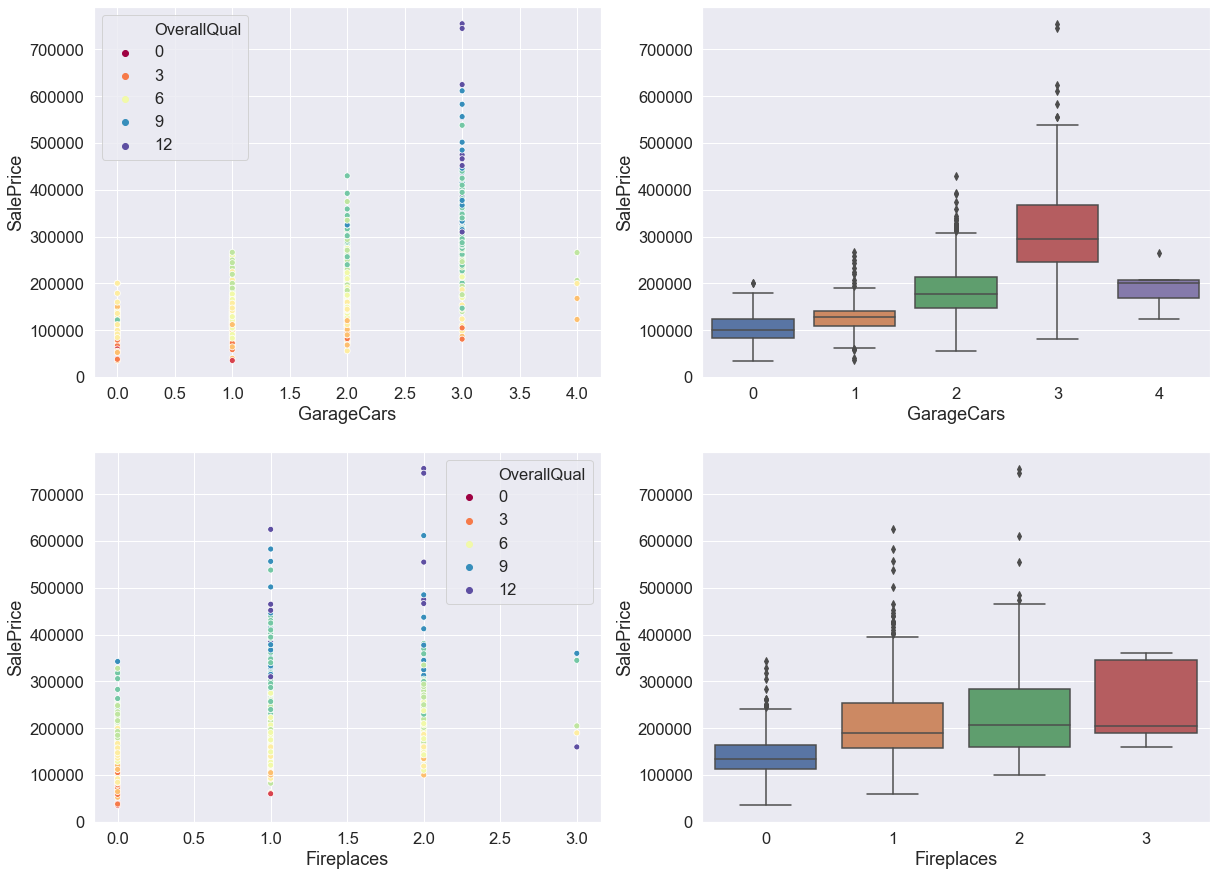

In [569]:
'''
Visualize "GarageCars", "Fireplaces" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for GarageCars and FirePlaces as well
'''

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig12 = fig.add_subplot(221); 
sns.scatterplot(x = df1.GarageCars, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig12_1 = fig.add_subplot(222);
sns.boxplot(x='GarageCars', y='SalePrice', data=df1[['SalePrice', 'GarageCars']])

fig9 = fig.add_subplot(223); 
sns.scatterplot(x = df1.Fireplaces, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

fig9_1 = fig.add_subplot(224);
sns.boxplot(x='Fireplaces', y='SalePrice', data=df1[['SalePrice', 'Fireplaces']])

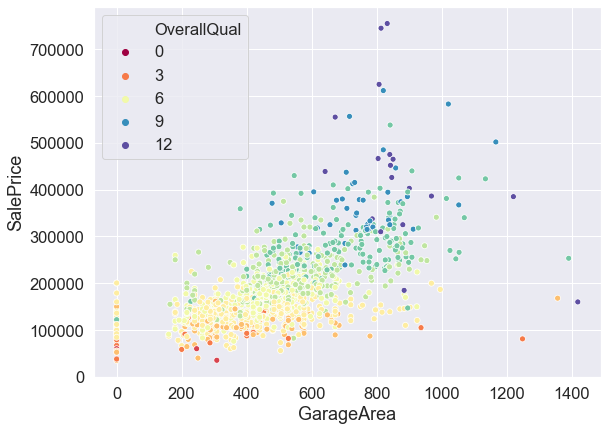

In [570]:
''' 
Visualize "GarageArea" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice
'''
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig11 = fig.add_subplot(223); 
sns.scatterplot(x = df1.GarageArea, y = df1.SalePrice, hue=df1.OverallQual, palette= 'Spectral')

### Plot Scatter plots and fit Regression Line to:

OverallQual/SalePrice

YearBuilt/SalePrice

YearRemodAdd/SalePrice

MasVnrArea/SalePrice

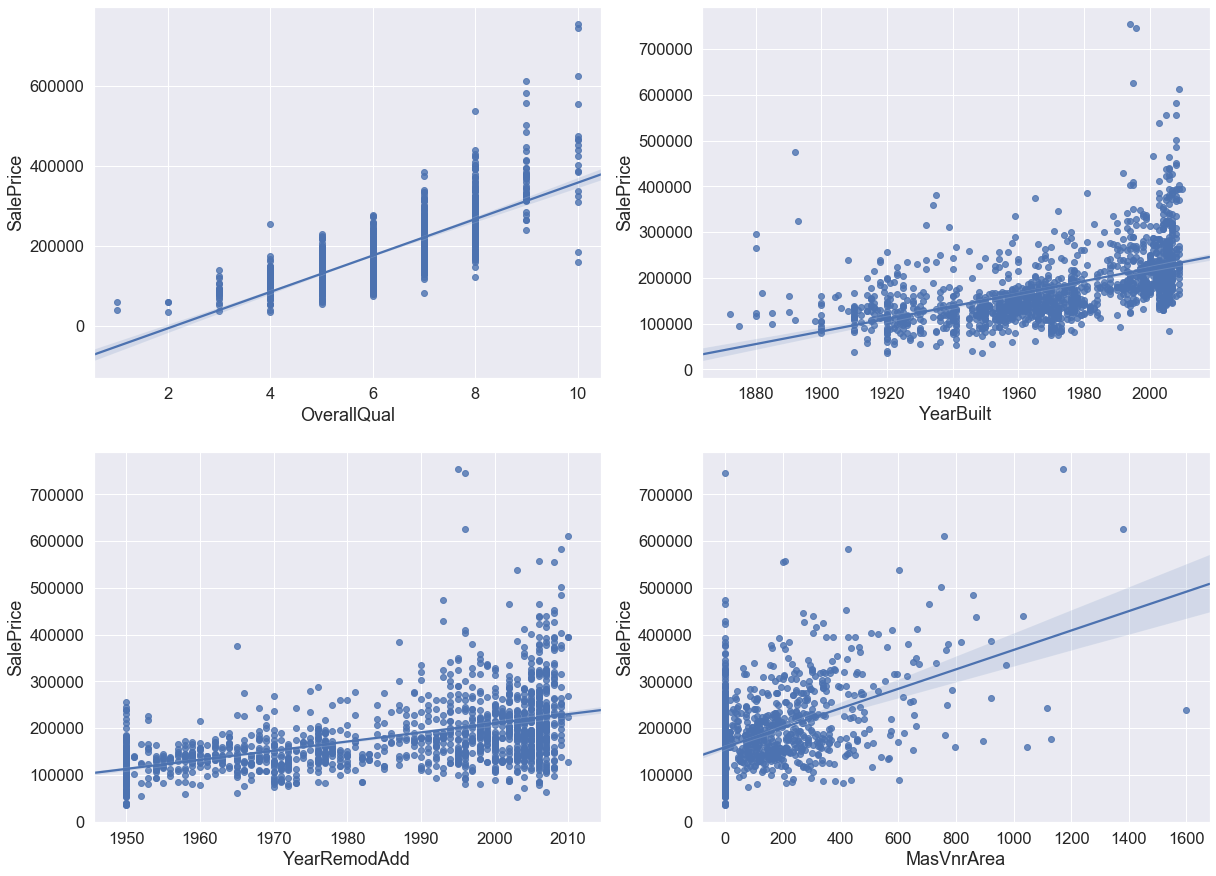

In [571]:
df1 = df1
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig1 = fig.add_subplot(221)
sns.regplot(x = df1.OverallQual, y = df1.SalePrice)

fig2 = fig.add_subplot(222); 
sns.regplot(x = df1.YearBuilt, y = df1.SalePrice)

fig3 = fig.add_subplot(223); 
sns.regplot(x = df1.YearRemodAdd, y = df1.SalePrice)

fig4 = fig.add_subplot(224); 
sns.regplot(x = df1.MasVnrArea, y = df1.SalePrice)

#### Observations:

"Overall Quality" has the highest correlation and this is evident from the upward sloping regression line in the first graph.

"Year build" and "Year Remodelled" have high correlation with upward sloping curves but are impacted by a number of outliers.

The shape of the regression line for "MasVnrArea" seems to be pulled up by the large outliers towards the far right end of the graph.

### Plot Scatter plots and fit Regression Line to:

TotalBsmtSF/SalePrice

1stFlrSF/SalePrice

GrLivArea/SalePrice

FullBath/SalePrice

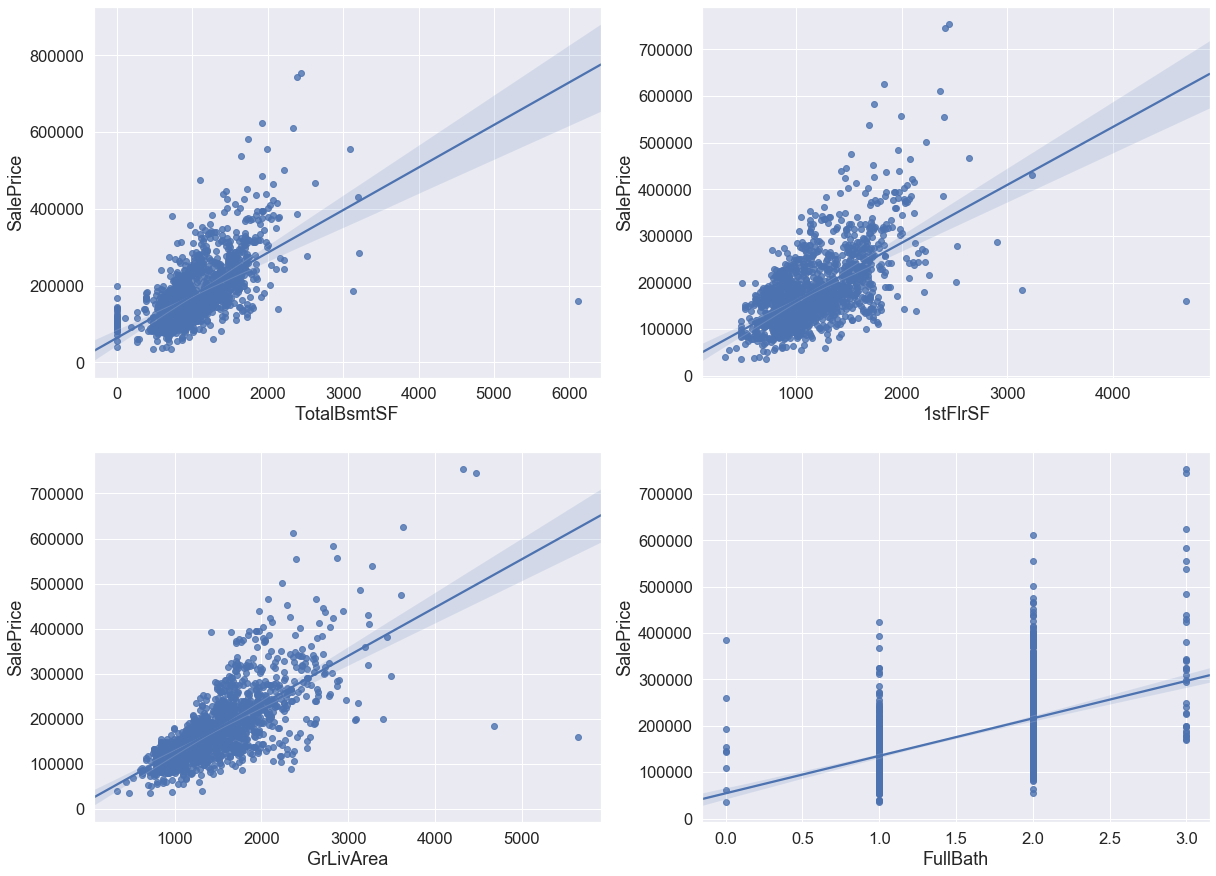

In [572]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig5 = fig.add_subplot(221); 
sns.regplot(x = df1.TotalBsmtSF, y = df1.SalePrice)

fig6 = fig.add_subplot(222); 
sns.regplot(x = df1['1stFlrSF'], y = df1.SalePrice)

fig7 = fig.add_subplot(223); 
sns.regplot(x = df1.GrLivArea, y = df1.SalePrice)

fig8 = fig.add_subplot(224); 
sns.regplot(x = df1.FullBath, y = df1.SalePrice)


#### Observations:

"TotalBsmtSF", "1stFlrSF", "GrLivArea" and "FullBath" have high correlation with upward sloping curves.

The outliers do not seem to have too much negative impact on the overall fit of the regression line.

### Plot Scatter plots and fit Regression Line to:

TotRmsAbvGrd/SalePrice

GarageYrBlt/SalePrice

GarageArea/SalePrice

GarageCars/SalePrice

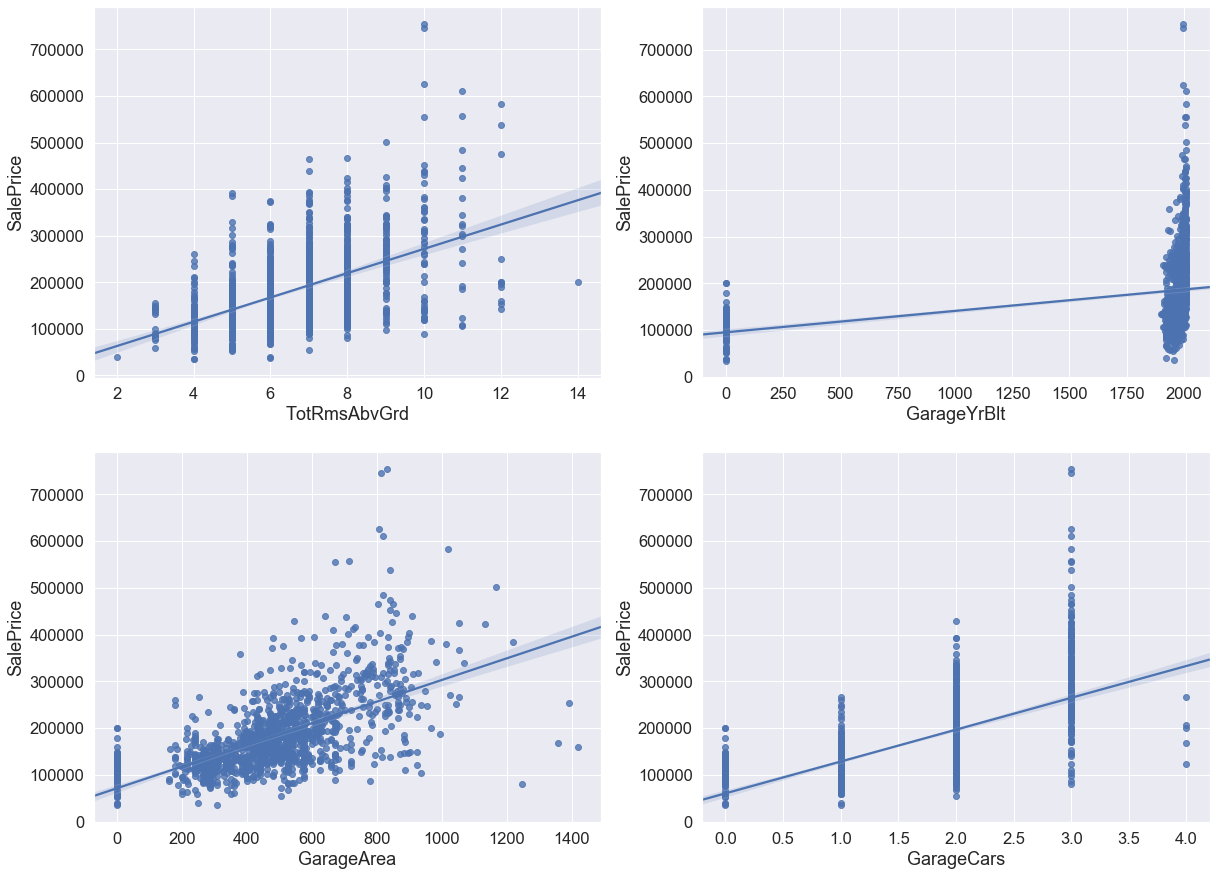

In [573]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig9 = fig.add_subplot(221); 
sns.regplot(x = df1.TotRmsAbvGrd, y = df1.SalePrice)

fig10 = fig.add_subplot(222); 
sns.regplot(x = df1.GarageYrBlt, y = df1.SalePrice)

fig11 = fig.add_subplot(223); 
sns.regplot(x = df1.GarageArea, y = df1.SalePrice)

fig12 = fig.add_subplot(224); 
sns.regplot(x = df1.GarageCars, y = df1.SalePrice)


#### Observations:

"TotRmsAbvGrd", "GarageArea", and "GarageCars" have high correlation with upward sloping curves.

The outliers on "TotRmsAbvGrd" and "GarageArea" do not seem to have too much negative impact on the overall fit of the regression line, however those in "GarageCars" specifically 4cars garage seem to pull the regression line downwards and may have a negative impact on its overall fit.

"GarageYrBlt" seems to be heavily influenced by the missing values. Its might be best to impute the missing values rather than replace the missing values with 0 to avoid this kind of impact of the overall fit.

### Plot Scatter plots and fit Regression Line to:

Fireplaces/SalePrice

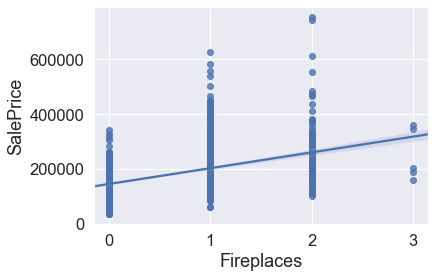

In [592]:
sns.regplot(x = df1.Fireplaces, y = df1.SalePrice)

#### Observation:

"Fireplaces" have high correlation with upward sloping curves. There are a few observable outliers that dont seem to have too much impact on the overall fit of the regression line.

# Machine Learning

##### (Optional Extra Credit)

Perform some machine learning on your manipulated data. You may use any ML algorithm you think would work on your data.

### Resources:

https://www.datacamp.com/community/tutorials/machine-learning-python
https://scikit-learn.org/stable/
    

In [575]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing


# We will use scikit-learn module
# Load training data set from the Kaggle website housing data competition
train = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/train.csv')

# Load testing data set
test = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/test.csv')

# Drop Id columns in both train and test sets since its not necessary
train_Id = train['Id']
train.drop('Id', axis=1, inplace=True)

test_Id = test['Id']
test.drop('Id', axis=1, inplace=True)

# Add a saleprice column into the test data set with zero values
test['SalePrice'] = 0

# Combine the two data sets and perform data clean up
data = pd.concat((train, test)).reset_index(drop=True)

# Perform a check of missing values
print('Is there missing values: ', data.isnull().values.any()) # True if there are missing values and False if not.

print(data.isnull().sum()) # To output total missing values per column (MasVnrArea - 8NA's, GarageYrBlt - 81NA's)

print('Total missing values: ', data.isnull().sum().sum()) # To put put total missing values


# Replace all the NA's with 0 for the columns (LotFrontage , MasVnrArea, GarageYrBlt) with missing data in the df dataframe
#data = data.fillna(0)

#Check for missing values after the replacement of NAs with 0
#print('Missing values after replacing all NAs with 0: ', data.isnull().sum().sum())


Is there missing values:  True
MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64
Total missing values:  13965


### Build a mapping scheme

In the next section I wanted to transform some of the obvious variables to numerical representation and in the process indirectly preserve their significance.

As an example:

Basement Quality:

Ex : 5 - Excellent

Gd : 4 - Good

TA : 3 - Typical

Fa : 2 - Fair

Po : 1 - Poor

NA : 0 - No Basement

We assign the numbers from 0 to 5 representing no basement to the highest quality (Excellent).

Rather than rewrite this entire code, I borrowed it from the :https://www.kaggle.com/mgmarques/houses-prices-complete-solution

*Credit to : "mgmarques"

In [576]:
# Building a mapping scheme to transform the ordinal features and preserving its significance:
# Code from: https://www.kaggle.com/mgmarques/houses-prices-complete-solution

data_transf = data

def map_ordinals(data):
    
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'

    data.LandSlope = data.LandSlope.map(LandSlope)
        
    # ExterQual: Evaluates the quality of the material on the exterior 
    ExterQual = {}
    ExterQual['Ex'] = 5 #'Excellent'
    ExterQual['Gd'] = 4 #'Good'
    ExterQual['TA'] = 3 #'Average/Typical'
    ExterQual['Fa'] = 2 #'Fair'
    ExterQual['Po'] = 1 #'Poor'
    ExterQual['NA'] = 0 #'NA'

    data.ExterQual = data.ExterQual.map(ExterQual)

    # ExterCond: Evaluates the present condition of the material on the exterior
    data.ExterCond = data.ExterCond.map(ExterQual)

    #HeatingQC: Heating quality and condition
    data.HeatingQC = data.HeatingQC.map(ExterQual)

    # KitchenQual: Kitchen quality
    data.KitchenQual = data.KitchenQual.map(ExterQual)

    # FireplaceQu: Fireplace quality
    data.FireplaceQu = data.FireplaceQu.map(ExterQual)

    # GarageCond: Garage Conditionals
    data.GarageCond = data.GarageCond.map(ExterQual)

    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'

    data.PavedDrive = data.PavedDrive.map(PavedDrive)

    # LotShape: General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'

    data.LotShape = data.LotShape.map(LotShape)

    # BsmtQual: Evaluates the height of the basement
    BsmtQual = {}
    BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
    BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
    BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
    BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
    BsmtQual['Po'] = 1 #'Poor (<70 inches'
    BsmtQual['NA'] = 0 #'No Basement'

    data.BsmtQual = data.BsmtQual.map(BsmtQual)

    # BsmtCond: Evaluates the general condition of the basement
    data.BsmtCond = data.BsmtCond.map(BsmtQual)

    # GarageQual: Garage quality
    data.GarageQual = data.GarageQual.map(BsmtQual)

    # PoolQC: Pool quality
    data.PoolQC = data.PoolQC.map(BsmtQual)
    
    # BsmtExposure: Refers to walkout or garden level walls
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'

    data.BsmtExposure = data.BsmtExposure.map(BsmtExposure)

    # BsmtFinType1: Rating of basement finished area
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1)

    # BsmtFinType2: Rating of basement finished area (if multiple types)
    data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    # Since with this transformatio as the same as binarize this feature
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1

    data.CentralAir = data.CentralAir.map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'
    
    data.GarageFinish = data.GarageFinish.map(GarageFinish)
    
    # Functional: Home functionality
    Functional = {}
    Functional['Typ'] = 7   # Typical Functionality
    Functional['Min1'] = 6  # Minor Deductions 1
    Functional['Min2'] = 5  # Minor Deductions 2
    Functional['Mod'] = 4   # Moderate Deductions
    Functional['Maj1'] = 3  # Major Deductions 1
    Functional['Maj2'] = 2  # Major Deductions 2
    Functional['Sev'] = 1   # Severely Damaged
    Functional['Sal'] = 0   # Salvage only

    data.Functional = data.Functional.map(Functional)
    
    #Street: Type of road access to property
    # Since with this transformatio as the same as binarize this feature
    Street = {}
    Street['Grvl'] = 0 # Gravel 
    Street['Pave'] = 1 # Paved

    data.Street = data.Street.map(Street)


    # Fence: Fence quality
    Fence = {}
    Fence['GdPrv'] = 5 #'Good Privacy'
    Fence['MnPrv'] = 4 #'Minimum Privacy'
    Fence['GdWo'] = 3 #'Good Wood'
    Fence['MnWw'] = 2 #'Minimum Wood/Wire'
    Fence['NA'] = 1 #'No Fence'

    data.Fence = data.Fence.map(Fence)
    #But No Fence has the higest median Sales Price. So I try to use it as categorical
            
    return data

new_data = map_ordinals(data_transf)

# Replace all the NA's with 0 for the columns (LotFrontage , MasVnrArea, GarageYrBlt) with missing data in the df dataframe
#new_data = new_data.fillna(0)



In [577]:
data_dum = new_data

# Code from: https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies

# Correct Categorical from int to str types
data_dum.MSSubClass = data_dum.MSSubClass.astype('str')
data_dum.MoSold = data_dum.MoSold.astype('str')

data_dum, dummies = one_hot_encode(data_dum)

#data_dum.to_csv('Output.csv')


24 categorical columns
Index(['MSSubClass', 'MSZoning', 'Alley', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 248 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(24), int64(32), uint8(192)
memory usage: 1.8 MB
None


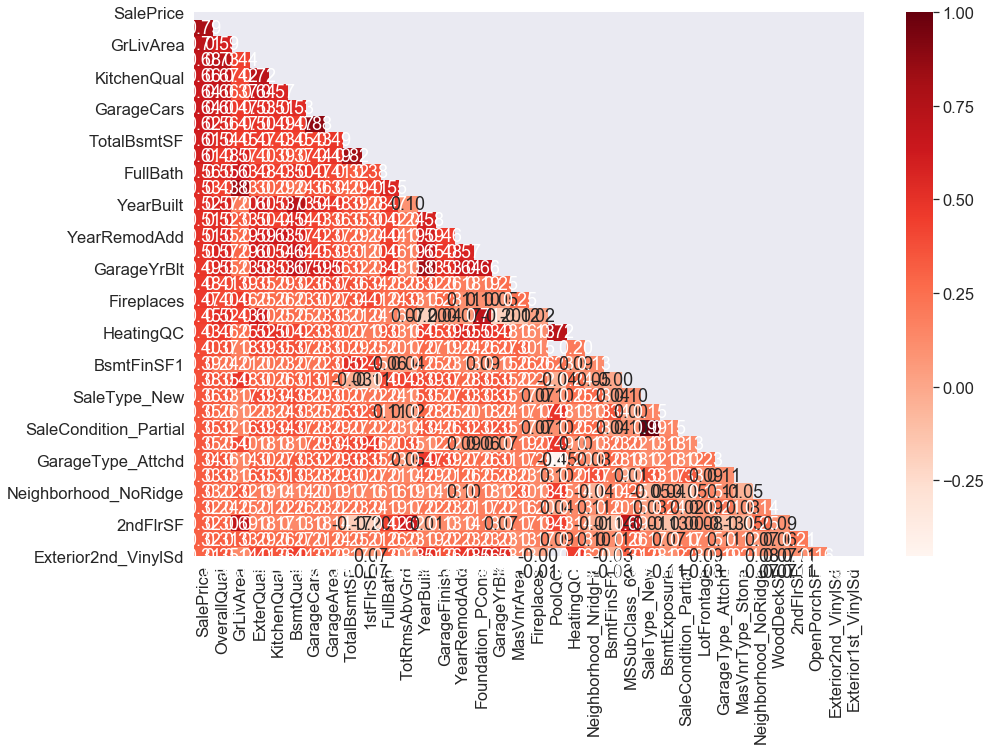

In [578]:
# Visualize the correlation coefficient of all variables including the dummies
corr = data_dum[data_dum.SalePrice>1].corr()

# Filter variables whose correlation to SalePrice is above 0.3 and sort in order of highest value
top_corr_cols = corr[abs((corr.SalePrice)>=.30)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]

# Drop self reference
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Plot the correlation into a heat map using searborn
plt.figure(figsize=(15, 10))
sns.heatmap(top_corr, annot=True, cmap=plt.cm.Reds, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()

In [579]:
#for col in data_dum.columns:
#    print(col)

cols = data_dum.columns 
#print(cols)

# Here we define as 'iunt8' all categorical variables
for c in cols:
    if data_dum[c].dtype == 'uint8':
        data_dum[c] = data_dum[c].astype('category')
        
# List all numeric features for further analysis        
numeric_features = list(data_dum.loc[:, cols].dtypes[(data_dum.dtypes != "category") & (data_dum.dtypes !='uint8')].index)

print(numeric_features)

['LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'YrSold', 'SalePrice']


In [580]:
# Correlation with output variable
cor = data_dum[data_dum.SalePrice>1].corr()
target_cor = abs(cor['SalePrice'])

# Select only variables with highly correlated features ie. those above 0.3
desired_features = target_cor[target_cor > 0.3]
print(desired_features)
print(len(desired_features))

# Create a dataframe with the desired features selected above
final_data = data_dum[["OverallQual", "YearBuilt", "YearRemodAdd", "MasVnrArea", "ExterQual", "BsmtQual", 
                      "TotalBsmtSF", "HeatingQC", "1stFlrSF", "GrLivArea", "FullBath", "KitchenQual", 
                      "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", 
                      "LotFrontage", "BsmtExposure", "BsmtFinSF1", "2ndFlrSF", "WoodDeckSF",
                      "OpenPorchSF", "SalePrice"]] 

print(final_data.head())

LotFrontage     0.351799
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
ExterQual       0.682639
BsmtQual        0.644019
BsmtExposure    0.352958
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
HeatingQC       0.427649
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
KitchenQual     0.659600
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageFinish    0.513105
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
PoolQC          0.447936
SalePrice       1.000000
Name: SalePrice, dtype: float64
26
   OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  BsmtQual  \
0            7       2003          2003       196.0          4       4.0   
1            6       1976          1976         0.0          3       4.0   
2            7       2001          2002       162.0          4       4.0   
3          

In [581]:
# splitting the dataset into the source variables (independant variables) and the target variable (dependant variable)
# Impute missing values on the final dataset
all_data = final_data.select_dtypes(include=[np.number]).interpolate().dropna()

# Extract training data from the final dataset to train the model
train_d = all_data.loc[(all_data.SalePrice>0)].reset_index(drop=True, inplace=False)
#print(train_d.info())

# Check for null values in teh extracted train dataset
print(sum(train_d.isnull().sum() != 0))

# Extract test data from the final dataset to test and submit final out put to kaggle housing data competition.
test_data = all_data.loc[(all_data.SalePrice==0)].reset_index(drop=True, inplace=False)

# Drop saleprice column from the test data: 
test_d = test_data.drop(['SalePrice'], axis=1)

# Drop the sales price to create the independ variable for training and testing phases
indp_vars = train_d.drop(['SalePrice'], axis=1)

# Create a target variable to only include the SalePrice - the dependent variable for both training and testing our model
target_var = train_d['SalePrice']

#print(indp_vars.head())

# Have 'X' represent the independent variables and 'y' the target variable (the dependent variable)
X = indp_vars
y = target_var


0


0.7536286648937035


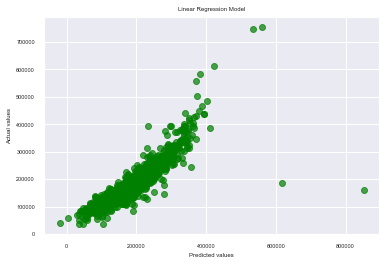

In [582]:
#Split data into train test set using the train_test_split() function in scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.8)

# Create a linear Regresion model
logreg = LinearRegression()

# Fit the Model to the training set
model = logreg.fit(X_train, y_train)

#Evaluate the performance  of the model
print(model.score(X_test, y_test))  

# Use the model to predict
predictions = model.predict(X_test)

# Graphically visualize the relationship between the predicted and the actual values
actual = y_test
plt.scatter(predictions, actual, alpha=.7, color='green') # Use alpha to show overlapping data
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Linear Regression Model')
plt.show()


In [583]:
# The Kaggle website requires a submission of the final result

# Create a kaggle dataframe and append test id from the test data
kaggle_submission = pd.DataFrame()
kaggle_submission['Id'] = test_Id

# Kaggle test data, not included in the training and testing sets in the previous section
submission_test = test_d

# Use the prediction model above to predict the SalePrice of the kaggle test data
kaggle_prediction = model.predict(test_d)

# Append the SalePrice column to the kaggle dataframe
kaggle_submission['SalePrice'] = kaggle_prediction

print(kaggle_submission.head())

# Write final submission into a csv file
kaggle_submission.to_csv('kaggle_submission.csv', index = False)


     Id      SalePrice
0  1461   99829.495590
1  1462  177174.773929
2  1463  177702.372146
3  1464  191926.217570
4  1465  189726.953166


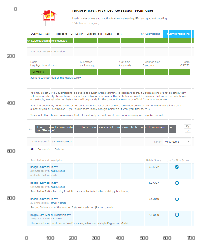

In [584]:
# See Kaggle submission results

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The submission results image is saved under my github account
#image = mpimg.imread("https://github.com/igukusamuel/DATA-605-Final-Project/blob/master/Kaggle_SubmissionFinal.PNG")
image = mpimg.imread("Kaggle_SubmissionFinal.PNG")
plt.imshow(image)
plt.show()

# Conclusions

Provide some conclusions or insight gained from looking at your data.


As we can see from our summary and exploratory statistics using the correlation matrix and in the correlation heatmap visualization, we were able to select key features. There key/desired feature we later used in the data wrangling section to create a final dataframe for our visualization analytics.

The desired fetures were selected in such a way to only include variables with a high correlation coefficient (greater than 0.3) to SaleData our target variable.

The final dataset is used to create visualizations from which we see the true nature of the relationship between the selected variables and the target variables including the impact of outliers.

Using the desired features we developed a regression model, trained and tested it on the train set on train_test_split of 0.8, 0.2 respectively. The model was then used to predict SalePrice on unseen data set.

The big challenge with this transformation is to be in a position to decide the outliers to exclude and if not, providing a viable justification for such a move. This requires careful analysis of the outliers on an individual basis and analysis its relationship with other variables which might skew the remaining data.

Thank you in advance and I look forward to your comments and feedback.

Samuel Kigamba